In [53]:

from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [51]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [50]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func
from sqlalchemy import create_engine, inspect, MetaData, Table

In [34]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///C:/Git Repos/hawaii.sqlite")

In [35]:
# Read in the CSV files since tables in Hawaii.sqlite file returned empty
measurements_df = pd.read_csv('C:/sqlalchemy-challenge/Vacay/Assignment materials/Resources/hawaii_measurements.csv')  # Importing file from CSV to Hawaii.sqlite
stations_df = pd.read_csv('C:/sqlalchemy-challenge/Vacay/Assignment materials/Resources/hawaii_stations.csv')  # Importing file from CSV to Hawaii.sqlite

# Write the dataframes to the SQLite database
measurements_df.to_sql('measurement', engine, if_exists='replace', index=False)
stations_df.to_sql('station', engine, if_exists='replace', index=False)

print("Database has been populated with 'measurement' and 'station' tables.")

Database has been populated with 'measurement' and 'station' tables.


In [36]:
from sqlalchemy import inspect

inspector = inspect(engine)
tables = inspector.get_table_names()
print("Tables found in the database:", tables) #Verify if the tables in Hawaii.sqlite has been populated

Tables found in the database: ['measurement', 'station']


In [80]:
# reflect an existing database into a new model
Base = automap_base()


# reflect the tables
#Base.prepare(autoload_with=engine)
Base.prepare(engine, reflect=True)


C:\Users\yzmen\AppData\Local\Temp\ipykernel_16056\998574426.py:7: SADeprecationWarning: The AutomapBase.prepare.reflect parameter is deprecated and will be removed in a future release.  Reflection is enabled when AutomapBase.prepare.autoload_with is passed.
  Base.prepare(engine, reflect=True)


In [81]:
# View all of the classes that automap found
print("Reflected tables:", Base.classes.keys()) # Method failed to reflect tables from the SQLite database

# Print out the available table names for debugging
#print("Available tables:", Base.classes.keys())

Reflected tables: []


In [59]:
# Save references to each table
measurement = Base.classes.measurement
station = Base.classes.station  # upon failure to reflect the tables in the SQLite database, accesibility to the tables failed.


AttributeError: measurement

In [57]:
# Use MetaData to manually reflect the database tables
metadata = MetaData()
metadata.reflect(bind=engine)

# Print the table names to confirm they are reflected
print("Tables found in the database:", metadata.tables.keys())

Tables found in the database: dict_keys(['measurement', 'station'])


In [58]:
# After using the metadata reflection method earlier
# And that `metadata` contains the table definitions.

# Save references to each table using the metadata approach:
# Create references to the tables
measurement_table = metadata.tables['measurement']
station_table = metadata.tables['station']

In [61]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Precipitation Analysis

In [64]:
# Find the most recent date in the data set.
latest_date = session.query(measurement_table.c.date).order_by(measurement_table.c.date.desc()).first()
latest_date = dt.datetime.strptime(latest_date[0], '%Y-%m-%d')
print(f"Latest Date: {latest_date}")


Latest Date: 2017-08-23 00:00:00


Date one year ago: 2016-08-23 00:00:00


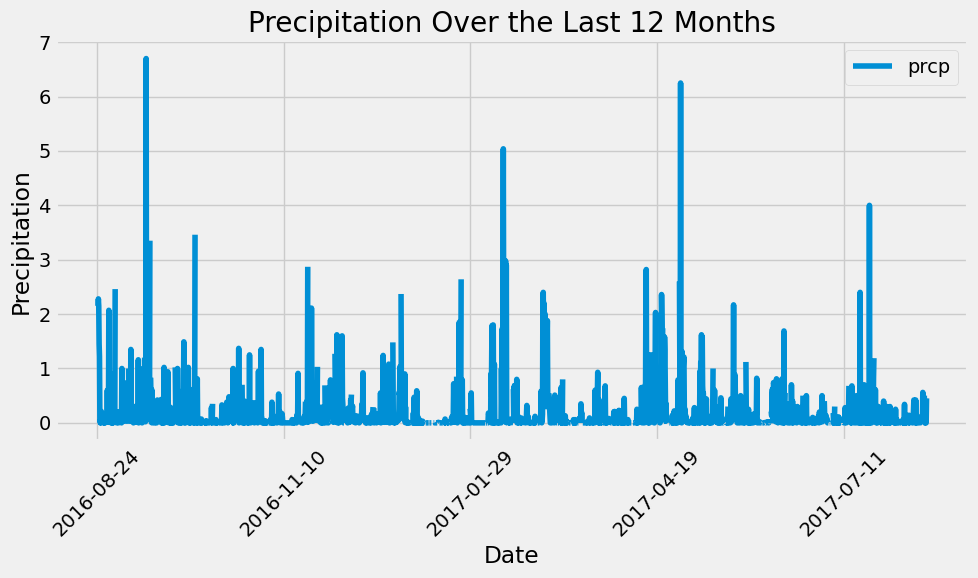

In [66]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 

# Calculate the date one year from the last date in data set.
one_year_ago = latest_date - dt.timedelta(days=365)
print(f"Date one year ago: {one_year_ago}")

# Perform a query to retrieve the data and precipitation scores using the manual table object.
precipitation_data = session.query(measurement_table.c.date, measurement_table.c.prcp)\
    .filter(measurement_table.c.date >= one_year_ago).all()

# Save the query results as a Pandas DataFrame. Explicitly set the column names.
precip_df = pd.DataFrame(precipitation_data, columns=['date', 'prcp'])

# Sort the dataframe by date.
precip_df = precip_df.sort_values(by='date')

# Use Pandas Plotting with Matplotlib to plot the data.
precip_df.set_index('date').plot(figsize=(10, 6), title='Precipitation Over the Last 12 Months')
plt.xlabel('Date')
plt.ylabel('Precipitation')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [67]:
# Use Pandas to calculate the summary statistics for the precipitation data
print(precip_df.describe())

              prcp
count  2015.000000
mean      0.176462
std       0.460288
min       0.000000
25%       0.000000
50%       0.020000
75%       0.130000
max       6.700000


# Exploratory Station Analysis

In [69]:
# Design a query to calculate the total number of stations in the dataset
total_stations = session.query(func.count(station_table.c.station)).scalar()
print(f"Total number of stations: {total_stations}")


Total number of stations: 9


In [71]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.
most_active_stations = session.query(
    measurement_table.c.station,
    func.count(measurement_table.c.station)
).group_by(measurement_table.c.station) \
    .order_by(func.count(measurement_table.c.station).desc()).all()

print("Most active stations:")
for station, count in most_active_stations:
    print(f"Station {station} - Observations: {count}")

# Get the station with the most observations
most_active_station = most_active_stations[0][0]
print(f"The most active station is {most_active_station}")


Most active stations:
Station USC00519281 - Observations: 2772
Station USC00519397 - Observations: 2724
Station USC00513117 - Observations: 2709
Station USC00519523 - Observations: 2669
Station USC00516128 - Observations: 2612
Station USC00514830 - Observations: 2202
Station USC00511918 - Observations: 1979
Station USC00517948 - Observations: 1372
Station USC00518838 - Observations: 511
The most active station is USC00519281


In [73]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
temps = session.query(
    func.min(measurement_table.c.tobs),
    func.avg(measurement_table.c.tobs),
    func.max(measurement_table.c.tobs)
).filter(measurement_table.c.station == most_active_station).all()

print(f"Temperature data for the most active station {most_active_station}:")
print(f"Min Temp: {temps[0][0]}, Avg Temp: {temps[0][1]:.2f}, Max Temp: {temps[0][2]}")

Temperature data for the most active station USC00519281:
Min Temp: 54, Avg Temp: 71.66, Max Temp: 85


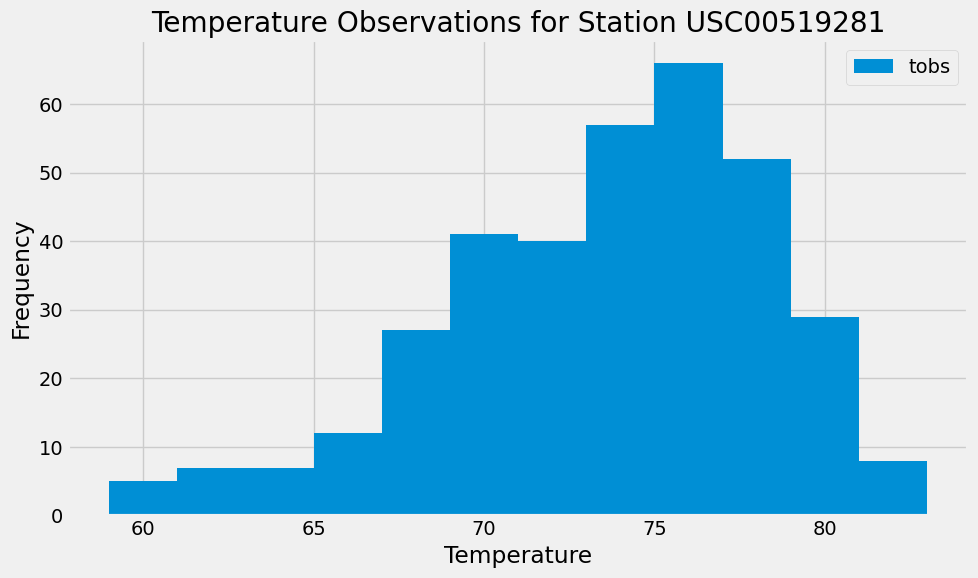

In [77]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
tobs_data = session.query(measurement_table.c.tobs) \
    .filter(measurement_table.c.station == most_active_station) \
    .filter(measurement_table.c.date >= one_year_ago).all()

# Convert the query results to a DataFrame
tobs_df = pd.DataFrame(tobs_data, columns=['tobs'])

# Plot the results as a histogram with bins=12
tobs_df.plot.hist(bins=12, figsize=(10, 6), title=f'Temperature Observations for Station {most_active_station}') 
plt.xlabel('Temperature')
plt.tight_layout()
plt.show()


# Close Session

In [78]:
# Close Session
session.close()